In [193]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
import ml_collections as mlc
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import torch
import pandas as pd
from torch.autograd.functional import jacobian
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.cancorr import CanCorr
from statsmodels.tsa.arima.model import ARIMA 
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (25, 5)
import seaborn as sns

from DGP import dgp 
from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, train
import BasicAutoEncoder
from BasicAutoEncoder.util import plot_factor_estimates, plot_train_hist, plot_reconstructed_y, get_trainable_params
from mcmc.ErrorProcess import IIDErrorProcess, ArErrorProcess
from mcmc.mcmc import trainMCMC
from BasicAutoEncoder.Metric import CCACorr
from Simulation.defaultCfg import cfg as defaultCfg
from Simulation.results import logResults


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
EXPERIMENT_NAME = 'CorrectSpecification'

## Set configuration

In [242]:
#Use default cfg, alternatively overwrite values
cfg = defaultCfg

#Set model specific config
cfg.enc_hidden_dim = [cfg.obs_dim, 10,20,40,50,60,70,80,90, cfg.factor_dim]
cfg.dec_hidden_dim = [cfg.factor_dim, 10,20,40,50,60,70,80,90, cfg.obs_dim]
cfg.enc_activation = nn.Tanh
cfg.dec_activation = nn.Tanh
cfg.enc_last_layer_linear = False
cfg.dec_last_layer_linear = True

#set experiment specifig training params
cfg.lr = 0.0008
cfg.n_epoch = 50
cfg.max_iter = 10
cfg.saved_index = 5
cfg.use_default_data  = True
cfg.batch_size = 256

## Obtain Data
Obtain the simulated $y$ and $f$

Decoder(
  (sequential): Sequential(
    (linear_0): Linear(in_features=10, out_features=20, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=20, out_features=40, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=40, out_features=80, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=80, out_features=100, bias=True)
    (activation_3): Tanh()
  )
)
(8192, 100) (1024, 100) (7168, 100)


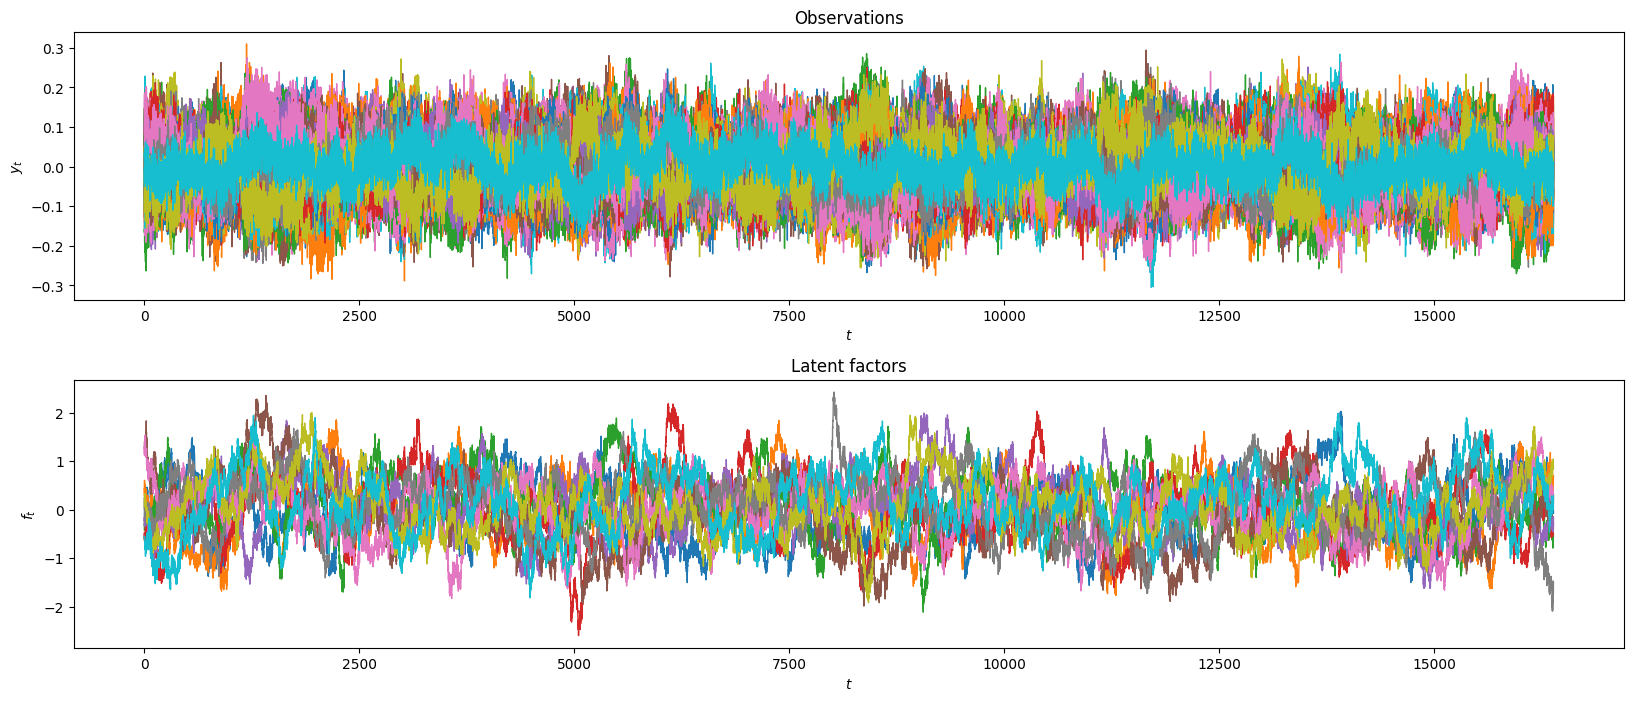

In [234]:
if cfg.use_default_data:
    f,y,dec = dgp.getSaved(cfg.saved_index, T=cfg.T)
    cfg.factor_dim = f.shape[1]
    cfg.obs_dim = y.shape[1]
else:
    #custom dgp
    dec = Decoder(hidden_dim=[cfg.factor_dim, 20, 40, 80, cfg.obs_dim], activation=nn.Tanh(), lastLayerLinear=False, use_xavier=False)
    f, y, obs_residual = dgp.getSimulatedNonlinearVarP(factor_dim=cfg.factor_dim,p=cfg.p_factor, obs_dim=cfg.obs_dim,T=cfg.T, dec=dec, covar_factor = cfg.covar_factor, p_eps = cfg.p_eps,covar_eps=cfg.covar_eps, normalized=False, centered=True)
print(dec)
f_train = f[0:cfg.T_train]
f_val = f[cfg.T_train:cfg.T_train+cfg.T_val]
f_test = f[cfg.T_train+cfg.T_val:]

y_train = y[0:cfg.T_train]
y_val = y[cfg.T_train:cfg.T_train+cfg.T_val]
y_test = y[cfg.T_train+cfg.T_val:]
print(y_train.shape, y_val.shape, y_test.shape)

fig,ax = plt.subplots(2,1, figsize=(20,8))
ax[0].plot(y, linewidth=1)
ax[0].set_title('Observations')
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$y_t$')
ax[1].plot(f, linewidth=1)
ax[1].set_title('Latent factors')
ax[1].set_ylabel('$f_t$')
ax[1].set_xlabel('$t$')
plt.subplots_adjust(hspace=0.3)

In [229]:
#torch.save(dec, '../DGP/saved/dec_5.pt')
#np.save(arr=y, file='../DGP/saved/y_5.npy')
#np.save(arr=f, file='../DGP/saved/f_5.npy')

## Estimate autoencoder model

In [251]:
dec = Decoder(hidden_dim=cfg.dec_hidden_dim, activation=cfg.dec_activation, lastLayerLinear=cfg.dec_last_layer_linear)
enc = Encoder(hidden_dim=cfg.enc_hidden_dim, activation=cfg.enc_activation, lastLayerLinear=cfg.enc_last_layer_linear)
#mod = AutoEncoder(enc=enc, dec=dec)
print(f"Number of trainable paramaters {get_trainable_params(mod)}")
errorProcess = IIDErrorProcess(n=cfg.obs_dim, T = cfg.T)
#errorProcess = ArErrorProcess(n=cfg.obs_dim, T = cfg.T, d=5)
metrics = [CCACorr(f_train=f_train, f_val=f_val)]

train_hist = trainMCMC(X_train=y_train, X_val = y_val, model=mod, errorProcess = errorProcess, n_epoch=cfg.n_epoch, lr = cfg.lr, batch_size=cfg.batch_size, metrics=metrics, max_iter = cfg.max_iter)
print(f"Training loss: {train_hist['train_loss'][-1]}, Validation Loss: {train_hist['val_loss'][-1]}")


/Users/julianvanmeggelen/Documents/Studie/2022:23/Thesis/Simulation/../BasicAutoEncoder/model.py:54: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(res[f"linear_{i}"].weight)


Number of trainable paramaters 57950
torch.Size([8192, 100]) torch.Size([1024, 100])
1 0.8904563765972853765972853
2 0.0024213610595325010595325015
3 0.0019635644712252542712252542
4 0.0018365044343227055343227055
5 0.0018174593133153394133153394
6 0.0018194677504652645504652645
7 0.0018236152500321623500321623
8 0.0018215657401015057401015054
9 0.0018160880208597519208597519
10 0.001820689412852516428525164
11 0.001817367981857387318573873
Training loss: 0.0018173679818573873, Validation Loss: 0.0009472855017520487


In [57]:
logResults(train_hist, mod, cfg, EXPERIMENT_NAME)

./Results/3/2_CorrectSpecification_05092023_23:28:51


### Train & val loss

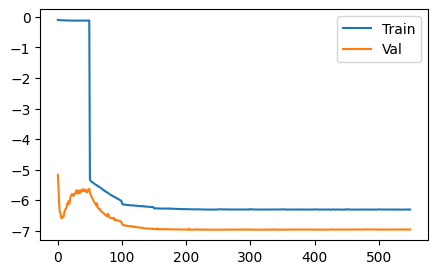

In [252]:
plot_train_hist(train_hist, log=True)

### Convergence of mu of epsilon

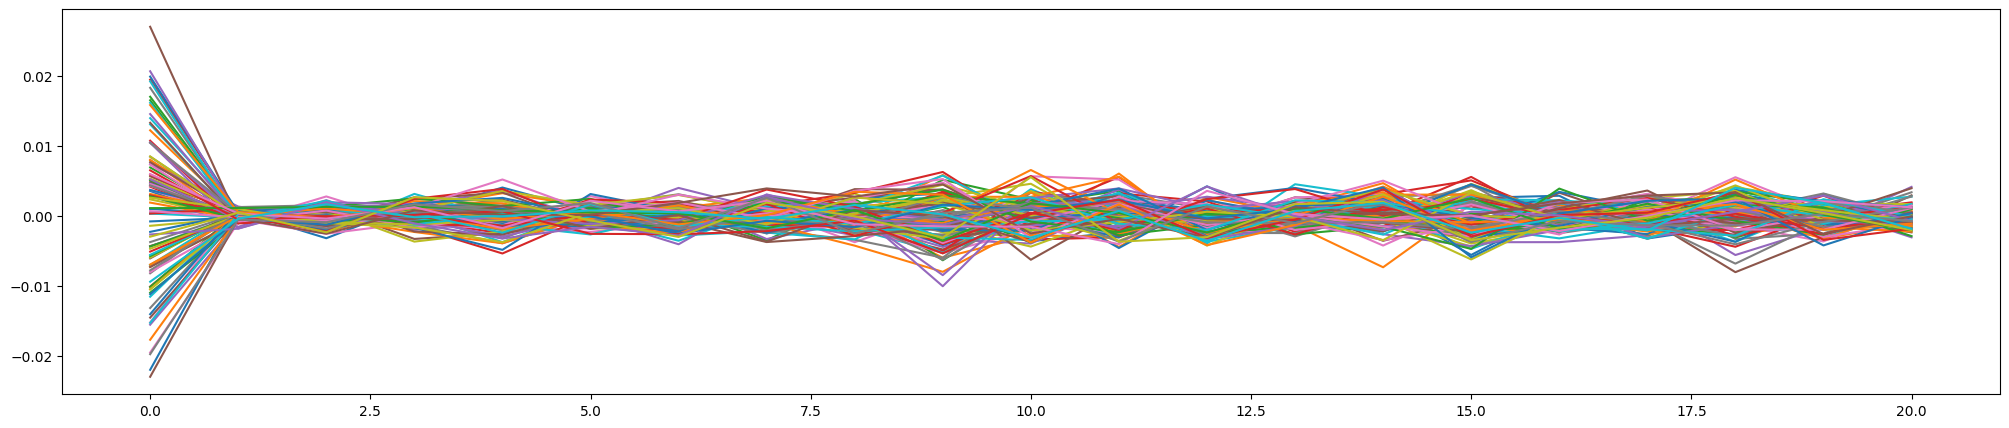

In [223]:
plt.plot(np.stack(errorProcess.fit_hist['mu']));

### Reconstruction of y

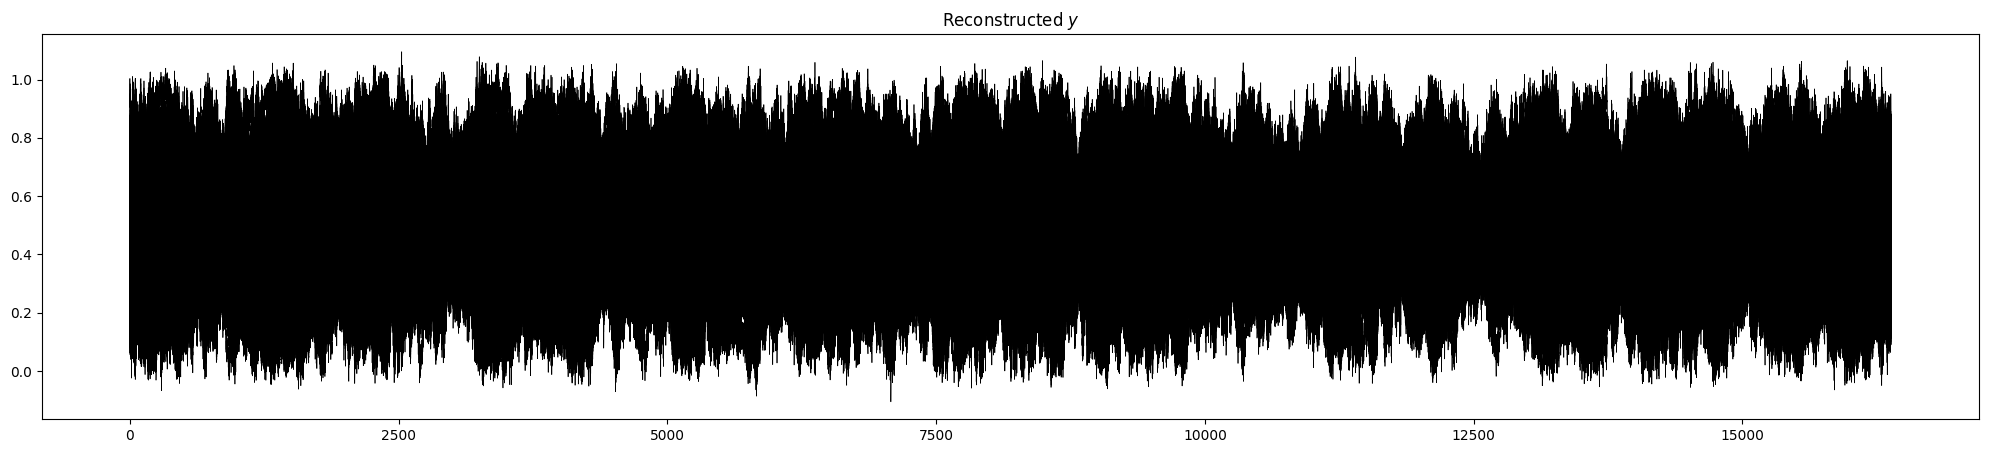

In [95]:
plot_reconstructed_y(mod, y, c='black', linewidth=0.5)
plt.plot(y, c='black', linewidth=0.5);


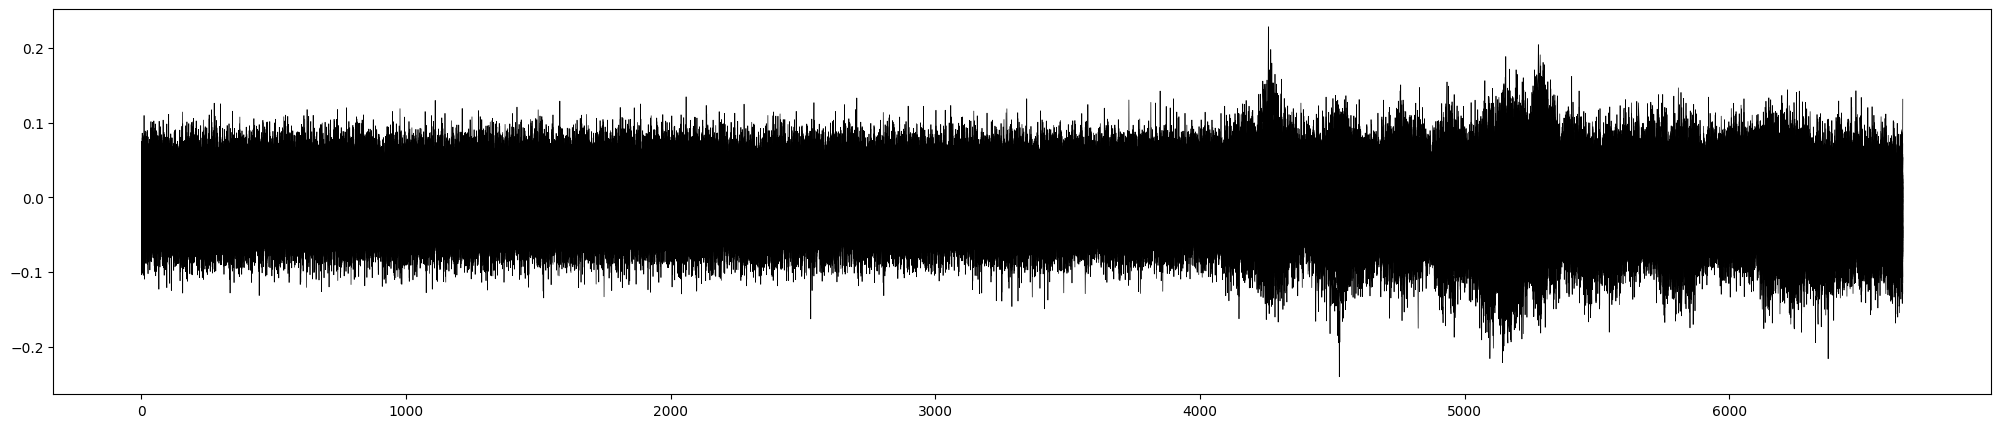

In [61]:
y_pred = mod(torch.Tensor(y)).detach().numpy()
plt.figure()
plt.plot(y_pred-y, c='black', linewidth=0.5);

### Factor estimation

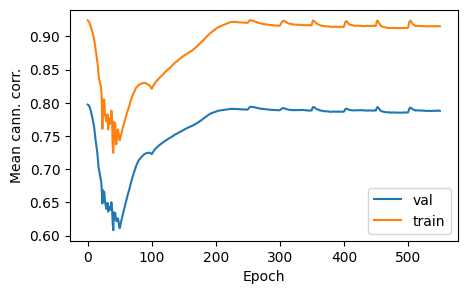

In [253]:
plt.figure(figsize=(5,3))
plt.plot(train_hist['val_CCA_mean_corr'], label='val')
plt.plot(train_hist['train_CCA_mean_corr'], label='train')

plt.xlabel('Epoch')
plt.ylabel('Mean cann. corr.')
plt.legend()

In [254]:
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
cancorr = CanCorr(f_train_hat, f_train)
cc = np.mean(cancorr.cancorr)
print(f"cc on train data: {cc}")
f_test_hat = mod.enc(torch.Tensor(y_test).float()).detach().numpy()
cancorr = CanCorr(f_test_hat, f_test)
cc = np.mean(cancorr.cancorr)
print(f"cc on test data: {cc}")

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_train_hat, f_train)
X_c, Y_c = cca.transform(f_train_hat, f_train)

print("cc on train data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

n_comps = cfg.factor_dim
cca = CCA(n_components=n_comps, scale=False)
cca.fit(f_test_hat, f_test)
X_c, Y_c = cca.transform(f_test_hat, f_test)

print("cc on test data: ", np.mean([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(n_comps)]))  

cc on train data: 0.915295936707494
cc on test data: 0.9044139845626648
cc on train data:  0.915295786645532
cc on test data:  0.9044138485750762


0.906097265979789 0.0187471363717483 [0.86455564 0.93819515]


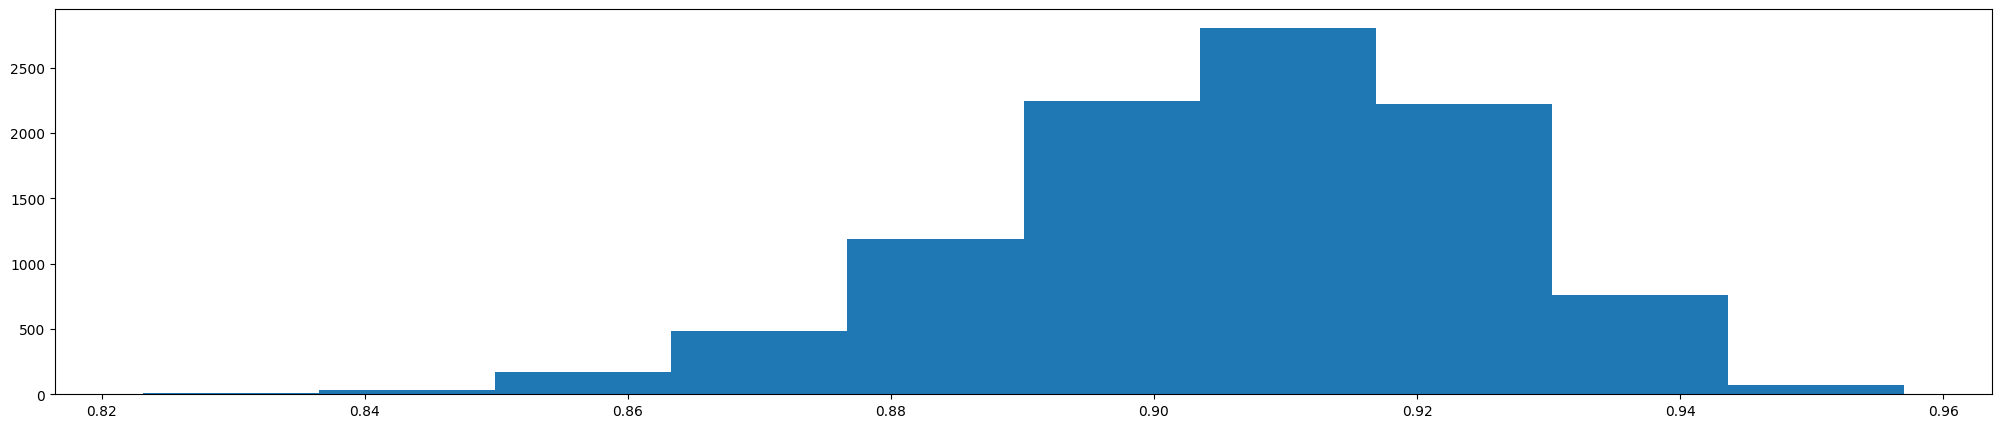

In [255]:
from evaluation import bootstrapCCA
bs = bootstrapCCA(f_hat=f_test_hat, f_true=f_test, n_bootstrap=10000, n_sample=30)
print(np.mean(bs), np.std(bs), np.quantile(bs, [0.025, 0.975]))
plt.hist(bs);

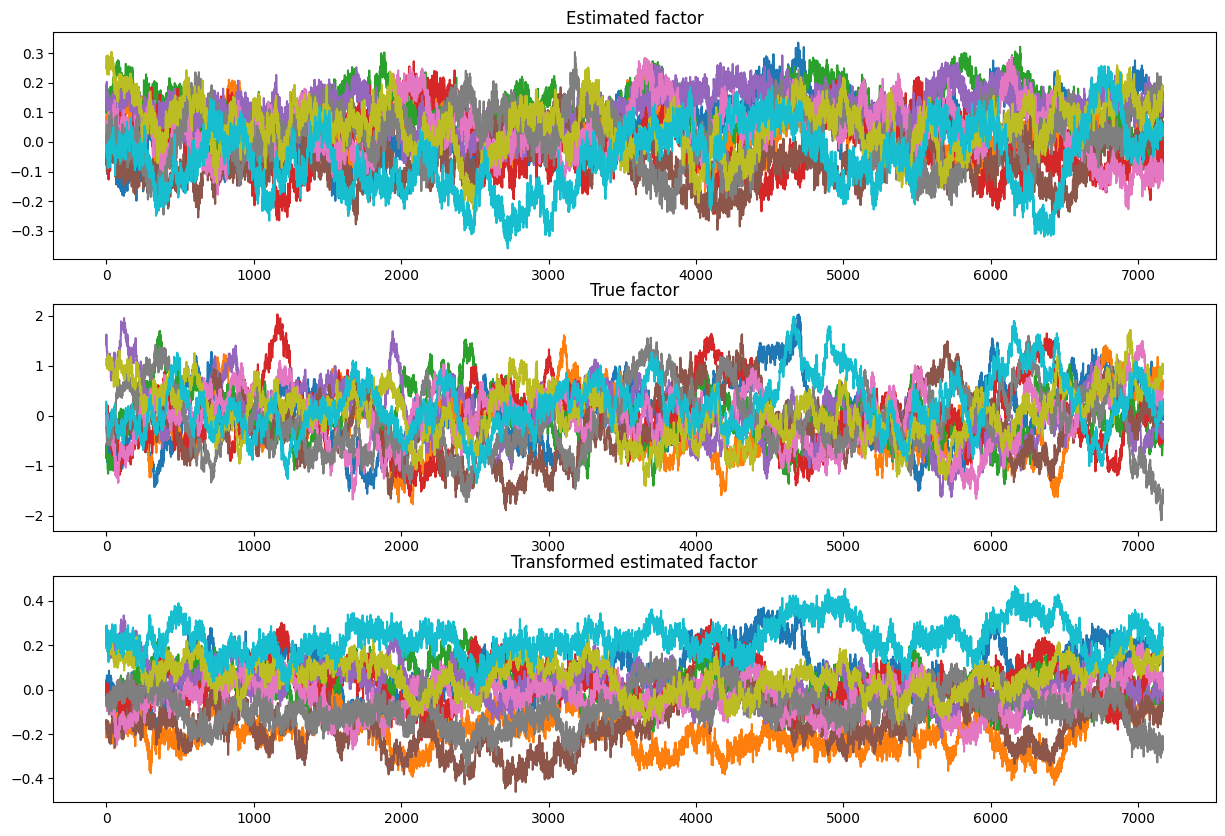

In [256]:
fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(f_test_hat);
ax[0].set_title('Estimated factor');
ax[1].plot(f_test);
ax[1].set_title('True factor');
ax[2].plot(cca.predict(f_test_hat));
ax[2].set_title('Transformed estimated factor');

### Forecast

In [257]:
#forecast
from statsmodels.tsa.vector_ar.var_model import VAR
f_train_hat = mod.enc(torch.Tensor(y_train).float()).detach().numpy()
f_val_hat = mod.enc(torch.Tensor(y_val).float()).detach().numpy()
f_hat = np.concatenate([f_train_hat, f_val_hat])
model = VAR(f_hat)
res = model.fit(maxlags=10, ic='aic')
test_model = VAR(np.concatenate([f_hat, f_test_hat]))
f_test_pred = test_model.predict(res.params, lags=res.k_ar)[-cfg.T_test:]
y_test_pred = mod.dec(torch.Tensor(f_test_pred).float()).detach().numpy()

fig,ax = plt.subplots(3,1, figsize=(15,10))
ax[0].plot(y_test_pred);
ax[0].set_title('1-step-ahead forecast for y');
ax[1].plot(y_test);
ax[1].set_title('True y');
ax[2].plot(y_test_pred - y_test);
ax[2].set_title('Residual');

print(f"1-step ahead  FMSE on the test set: {np.mean((y_test_pred-y_test)**2)}")

1-step ahead  FMSE on the test set: 0.001120314234867692


In [134]:
from dm import in_MDM_test
e1 = np.sum(y_test_pred[0:200]-y_test[0:200],axis=1)
e2 = np.sum(y_test_pred[200:400]-y_test[200:400],axis=1)
d = np.vstack([e1,e2])
in_MDM_test(d, q=3, statistic='Sc')


[array([-4.83519267, -0.88930998]),
 {'statistic': array([[24.69429677]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[4.34211768e-06]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 4.79529500e-01 -9.63633358e-02  1.78181291e-01  1.16548568e-01\n   1.31618828e-01 -4.70486283e-02 -4.49910820e-01 -3.44798893e-01\n  -5.85365057e-01 -1.58060282e-01  3.49326044e-01  2.09747851e-01\n  -5.88828027e-02  7.58422166e-02  7.17078984e-01  5.64274907e-01\n   8.31719577e-01 -4.11872178e-01  2.06792831e-01  2.98056751e-02\n   1.44059241e-01  5.46021879e-01 -1.76732197e-01 -5.81284016e-02\n  -7.22203672e-01 -7.15541005e-01 -9.72125113e-01 -5.39268851e-01\n  -2.25835085e-01 -3.37127507e-01 -2.69950330e-01 -8.04915190e-01\n  -2.16774508e-01  9.71347690e-02  9.16699469e-02 -4.30077851e-01\n  -1.27607846e+00 -8.94060969e-01  4.18439329e-01  2.32095599e-01\n  -2.89919317e-01 -1.82350159e-01  3.39898407e-01 -3.65081489e-01\n  -5

In [192]:
a = np.array([1,2,3,4,5,6,7,1,2,3,4,5,6,7])
b = np.array([1,0,0,0,0,2,0,0,0,1,0,0,0,0])
realized =  np.array([2,2,2,2,2,2,2,2,2,2,2,2,2,2])
d = np.stack([(a-realized)**2, (b-realized)**2])
q = 3
in_MDM_test(d, q=3, statistic='Sc')


[array([2.20895601, 0.85136117]),
 {'statistic': array([[2.82956626]]),
  'parameter': 3,
  'alternative': 'Equal predictive accuracy does not hold.',
  'p.value': array([[0.2429783]]),
  'method': 'multivariate Diebold-Mariano test',
  'data.name': '[[ 1  0  1  4  9 16 25  1  0  1  4  9 16 25]\n [ 1  4  4  4  4  0  4  4  4  1  4  4  4  4]]'}]

In [114]:
np.sum(y_test_pred-y_test,axis=1).shape

(7168,)

In [132]:
y_test_pred[0:300].shape

(300, 100)

In [151]:
np.concatenate([y_val,y_test][0:100]).shape

(8192, 100)

In [180]:
from evaluation import expandingWindowForecast
ewf = expandingWindowForecast(mod=mod,y_train = y_train, y_test = np.concatenate([y_val,y_test])[0:20])

(1, 100)
(8193, 100) (19, 100)
(1, 100)
(8194, 100) (18, 100)
(1, 100)
(8195, 100) (17, 100)
(1, 100)
(8196, 100) (16, 100)
(1, 100)
(8197, 100) (15, 100)
(1, 100)
(8198, 100) (14, 100)
(1, 100)
(8199, 100) (13, 100)
(1, 100)
(8200, 100) (12, 100)
(1, 100)
(8201, 100) (11, 100)
(1, 100)
(8202, 100) (10, 100)
(1, 100)
(8203, 100) (9, 100)
(1, 100)
(8204, 100) (8, 100)
(1, 100)
(8205, 100) (7, 100)
(1, 100)
(8206, 100) (6, 100)
(1, 100)
(8207, 100) (5, 100)
(1, 100)
(8208, 100) (4, 100)
(1, 100)
(8209, 100) (3, 100)
(1, 100)
(8210, 100) (2, 100)
(1, 100)
(8211, 100) (1, 100)
(1, 100)
(8212, 100) (0, 100)


In [172]:
np.mean(ewf,axis=1).shape

(20, 100)

In [176]:
ewf[0].shape

(1, 100)

In [179]:
np.vstack(ewf).shape

(20, 100)

(100,)


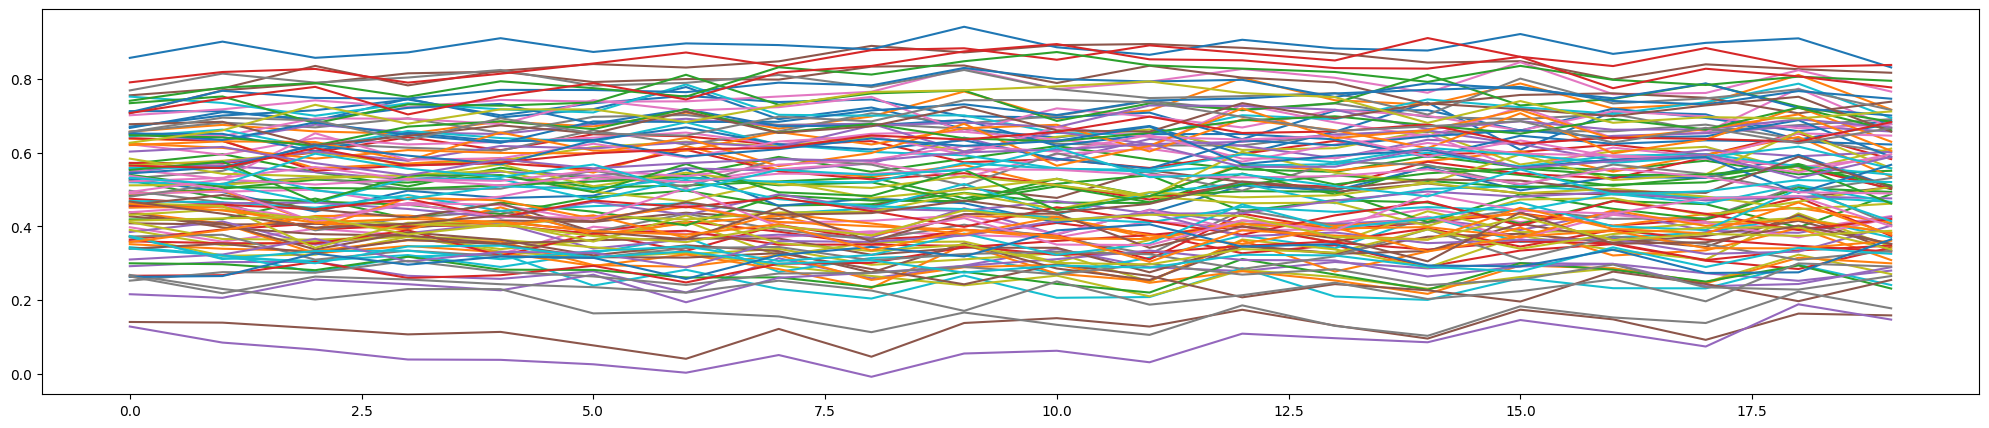

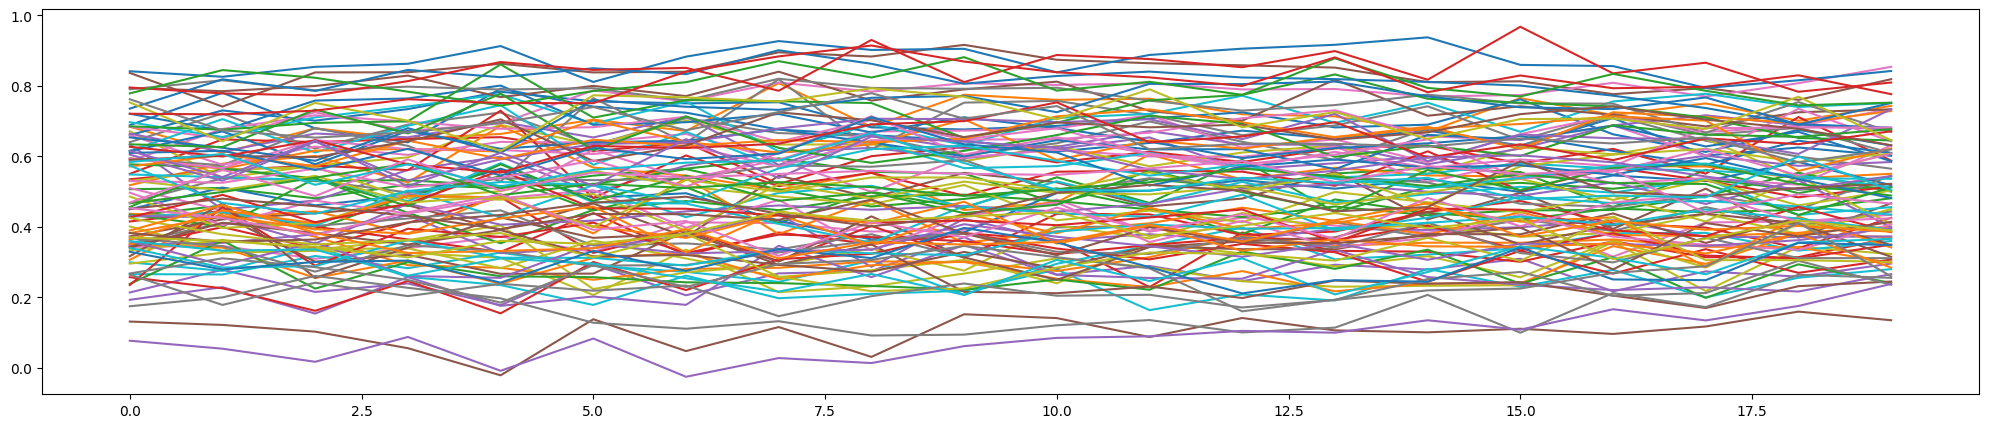

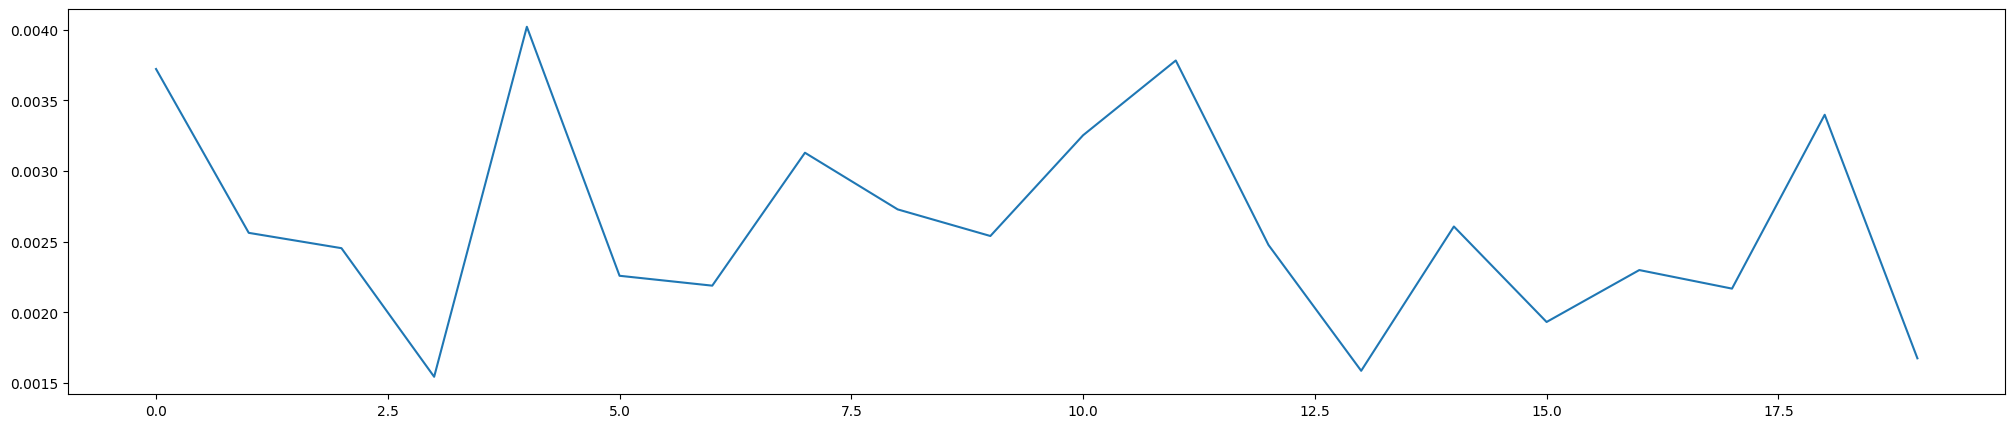

In [190]:
plt.plot(ewf);
plt.figure()
plt.plot(np.concatenate([y_val,y_test])[0:20]);
print(np.mean(ewf - np.concatenate([y_val,y_test])[0:20], axis=0).shape)
plt.figure()
plt.plot(np.mean((ewf - np.concatenate([y_val,y_test])[0:20])**2, axis=1))